In [1]:
from os.path import join as path_join
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup
from os.path import isfile
import pandas as pd
import numpy as np
import matplotlib
import warnings
import requests
import operator
import json
import sys
import os
import re

pd.options.display.float_format = '{:.4g}'.format

import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools

py.init_notebook_mode(connected=True)

In [2]:
CITY = "spb"
DEBUG = True

In [3]:
if DEBUG:
    warnings.filterwarnings('ignore')

In [4]:
def load_json(fn):
    with open(fn, "r") as f:
        return json.load(f)

nb_settings = load_json("notebooks_settings.json")  
city_center = nb_settings[CITY]['city_center']
opposite_city = nb_settings[CITY]['opposite_city']
language = nb_settings[CITY]['language']

In [5]:
osm_area_key = 'area'

project_path = "/Users/pavel/Sources/python/concepts/insta/"

scenes_path_template = "cv_sandbox/photo_tagger/scenes_{}.json"
scenes_path = scenes_path_template.format(CITY)
scenes_opposite_path = scenes_path_template.format(opposite_city)

photos_path_template = "public/photos/{}/"
photos_path = photos_path_template.format(CITY)
photos_opposite_path = photos_path_template.format(opposite_city)

adresses_path = "scripts/adresses/adresses_{}.csv".format(CITY)

wiki_path = "../../../scripts/wiki"

token_file = "mapbox.token"
MAPBOX_TOKEN = open(token_file, "r").readlines()[0]

In [6]:
fn1 = path_join(project_path, scenes_path.format(CITY))
data1 = load_json(fn1)

In [7]:
path = path_join(project_path, photos_path)
loc_file = list(map(lambda x: x.strip().split(","), open(path_join(path, "loc_info.csv"), "r").readlines()[1:]))
id2loc = {x[0]: x[1] for x in loc_file}

In [8]:
def relevant_places(tag, n_top=100):
    d = {}
    for loc in list(data1.keys()):
        loc_val = 0
        for photo in data1[loc]:
            val = 0
            if tag in data1[loc][photo]['categories']:
                val = data1[loc][photo]['categories'][tag]
            loc_val += float(val)
        if loc_val > 0:
            d[loc] = loc_val
    return sorted(d.items(), key=operator.itemgetter(1), reverse=True)[:n_top]

## Locations popularity

In [9]:
def title(s):
    return s.title()

def area_normalize_ru(s):
    stopword = "район"
    
    abbreviations = {"административный округ": "АО"}
    s = s.replace(stopword, "").strip()
    for x in abbreviations:
        s = s.replace(x, abbreviations[x]).strip()
    return s


def street_normalize_ru(s):
    abbreviations = {'Улица': 'Ул.', 
                     'Проспект': 'Пр-т', 
                     'Набережная': 'Наб.', 
                     'Проезд': 'Пр-д', 
                     'Бульвар': 'Бул.',
                     'Площадь': 'Пл.',
                     'Крепость': 'Кр-ть'}
    for x in abbreviations:
        s = s.replace(x, abbreviations[x]).strip()
    return s

In [10]:
# FIXME: paths
project_path_new = '/Users/pavel/Sources/python/concepts/insta/public/'
adresses_dir = path_join(project_path_new, 'data/adresses/')
adresses_path = path_join(adresses_dir, 'adresses_{}.csv'.format(CITY))

geo_table = pd.read_csv(adresses_path, error_bad_lines=False)

geo_table = geo_table.drop_duplicates()

In [11]:
STREET_COLUMN = 'route'

geo_table[STREET_COLUMN] = list(map(title, 
                                    geo_table[STREET_COLUMN].tolist()))

streets = geo_table[STREET_COLUMN].tolist()
areas = geo_table[osm_area_key].tolist()

street_locations_n = sorted(Counter(streets).items(), 
                             key=operator.itemgetter(1), reverse=True)

area_locations_n = sorted(Counter(areas).items(), 
                           key=operator.itemgetter(1), reverse=True)
###

TOP_AREAS_N = 10
TOP_STREETS_N = 100
TOP_STREETS_VIS = 20

areas = [x[0] for x in area_locations_n[1:TOP_AREAS_N+1]] 
area_activity = [x[1] for x in area_locations_n[1:TOP_AREAS_N+1]]

streets = [x[0] for x in street_locations_n[1:TOP_STREETS_N+1]]
map_streets = [x[0] for x in street_locations_n]
street_activity = [x[1] for x in street_locations_n[1:TOP_STREETS_N+1]]
map_streets_activity = [x[1] for x in street_locations_n]

In [12]:
geo_table['longtitude'] = geo_table['longtitude'].astype(float)
geo_table['latitude'] = geo_table['latitude'].astype(float)

avg_coords_table = geo_table[[STREET_COLUMN, 'longtitude','latitude']].groupby(STREET_COLUMN).agg(np.mean).reset_index()

locations_counter_table = geo_table[STREET_COLUMN].value_counts().reset_index()
locations_counter_table.columns = [STREET_COLUMN, 'counter']

streets_table = pd.merge(avg_coords_table, 
                         locations_counter_table, 
                         on=STREET_COLUMN).sort_values(by='counter', ascending=False)

streets_table = streets_table[streets_table[STREET_COLUMN] != 'None']

In [13]:
class CityMapStyle:
    MARKER_SIZE = 17
    MARKER_OPACITY = 0.4
    MARKER_COLOR = 'red'
    ZOOM = 12
    MAP_WIDTH = 800
    MAP_HEIGHT = 470
    MAX_MARKER_SIZE = 40
    MIN_MARKER_SIZE = 3
    MIN_LOCATIONS = 15
    MARGIN = dict(l=0, r=30, b=0, t=20)
    
    
def city_map(lat, lon, streets, streets_locations_number):
    style = CityMapStyle
    
    labels = [x if streets_locations_number.iloc[j] > style.MIN_LOCATIONS
                   else "" for j, x in enumerate(streets_locations_number)]
    marker_sizes = [x if x < style.MAX_MARKER_SIZE else style.MAX_MARKER_SIZE 
                    for x in streets_locations_number]
    marker_sizes = [x if x > style.MIN_MARKER_SIZE else style.MIN_MARKER_SIZE
                    for x in marker_sizes]

    
    round3 = lambda x: round(float(x), 3)
    hover_template = "<i>{}</i><br>coords: {:.3f} {:.3f}<br>n_locations: {}"
    hover_func = lambda x, y, z, zz: hover_template.format(x, round3(y), round3(z), zz)
    scatter_hover = list(map(hover_func, streets, lat, lon, streets_locations_number))
    marker_labels = [str(x) if x >= 20 else "" for x in marker_sizes]

    data = [go.Scattermapbox(
                lat=lat,
                lon=lon,
                mode='markers',
                marker=dict(
                    size=marker_sizes,
                    color=style.MARKER_COLOR,
                    opacity=style.MARKER_OPACITY),
                text=scatter_hover,
                hoverinfo='text'),
            
           go.Scattermapbox(
                lat=lat,
                lon=lon,
                mode='text',
                marker=dict(
                    size=marker_sizes,
                    color=style.MARKER_COLOR,
                    opacity=style.MARKER_OPACITY),
                text=marker_labels,
                textfont=dict(color='darkred', family='arial'),
                hoverinfo='none')]

    layout = go.Layout(
                width=style.MAP_WIDTH,
                height=style.MAP_HEIGHT,
                hovermode='closest',
                margin=style.MARGIN, 
                showlegend=False,
                mapbox=dict(
                    accesstoken=MAPBOX_TOKEN,
                    center=dict(
                        lat=city_center[0],
                        lon=city_center[1]),
                    zoom=style.ZOOM,
                    style='light'))

    fig = dict(data=data, layout=layout)
    py.iplot(fig, show_link=False)    

city_map(streets_table['longtitude'].tolist(), 
         streets_table['latitude'].tolist(), 
         streets_table[STREET_COLUMN], 
         streets_table['counter'])

In [14]:
class StreetAreaCombine:
    HOLE = 0.5
    PULL = 0.05
    PIE_AREA_X = [0.1, 1.0]
    PIE_AREA_Y = [0.2, 0.8]
    BAR_CHART_OPACITY = 0.8
    BAR_CHART_COLOR = 'red'
    BAR_CHART_CM = "Wistia"
    BAR_CHART_LEGEND_X = 0.55
    BAR_CHART_LEGEND_Y = 0.0
    
    TICK_LEN = 4
    PLOT_HEIGHT = 350
    PLOT_WIDTH = 900
    BAR_CHART_AREA_X = [0, 0.25]
    BAR_CHART_AREA_Y = [0, 1.0]
    MARGIN = go.layout.Margin(l=220, t=15, b=15, r=0)
    
    BAR_CHART_FONT_COLOR = 'lightgrey'
    BAR_CHART_FONT_SIZE = 11
    PIE_CHART_FONT_COLOR = 'grey'
    PIE_CHART_FONT_SIZE = 11
    
    MIN_COLOR_VALUE = 0.20
    MAX_COLOR_VALUE = 0.60    

    
def street_area_combine_plot(streets_barchart_y, 
                             streets_barchart_x,
                             lat, lon,
                             areas_barchart_values, 
                             areas_piechart_labels):    
    style = StreetAreaCombine
    
    colormap = matplotlib.cm.get_cmap(style.BAR_CHART_CM)
    
    norm_val = np.linspace(style.MAX_COLOR_VALUE, 
                           style.MIN_COLOR_VALUE, 
                           len(areas_barchart_values))
    
    pieces_colors = list(map(lambda x: 
                             matplotlib.colors.rgb2hex(colormap(x)), 
                             norm_val))
    
    round3 = lambda x: round(float(x), 3)
    hover_format = lambda x, y, z: "{}<br>{:.3f} {:.3f}".format(x, round3(y), round3(z))
    bar_hover = list(map(hover_format, streets_barchart_y, lat, lon))

    if language == 'ru':
        streets_barchart_y = list(map(street_normalize_ru, streets_barchart_y))
        areas_piechart_labels = list(map(area_normalize_ru, areas_piechart_labels))
    
    data = [go.Bar(y=streets_barchart_y,
                    x=streets_barchart_x,
                    marker=dict(color=style.BAR_CHART_COLOR), 
                    orientation='h',
                    text=bar_hover,
                    hoverinfo='text',
                    opacity=style.BAR_CHART_OPACITY, 
                    showlegend=False),

            go.Pie(values=areas_barchart_values,
                    labels=areas_piechart_labels,
                    domain=dict(x=style.PIE_AREA_X, 
                                y=style.PIE_AREA_Y),
                    hoverinfo="label+percent+value",
                    textinfo='label+value', 
                    textposition='outside',
                    hole=style.HOLE,
                    sort=False,
                    textfont=dict(size=style.PIE_CHART_FONT_SIZE, 
                                  color=style.PIE_CHART_FONT_COLOR),
                    marker=dict(colors=pieces_colors), 
                    pull=style.PULL)]
    
    layout = go.Layout(height=style.PLOT_HEIGHT, 
                       width=style.PLOT_WIDTH,
                       showlegend=False, 
                       margin=style.MARGIN, 
                       hovermode='closest',
                       xaxis=dict(domain=style.BAR_CHART_AREA_X, 
                                  tickfont=dict(color=style.BAR_CHART_FONT_COLOR,
                                                size=style.BAR_CHART_FONT_SIZE)),
                       yaxis=dict(domain=style.BAR_CHART_AREA_Y, 
                                  autorange="reversed", 
                                  ticklen=style.TICK_LEN, 
                                  tickfont=dict(size=style.BAR_CHART_FONT_SIZE, 
                                                color=style.BAR_CHART_FONT_COLOR)))
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, show_link=False)

    
N_AREAS_VISUALIZED = 5
N_STREETS_VISUALIZED = 20
OTHER_LABEL = "Other"

streets_table_shrinked = streets_table[:N_STREETS_VISUALIZED]
area_activity_shrinked = area_activity[:N_AREAS_VISUALIZED] + [sum(area_activity[N_AREAS_VISUALIZED+1:])]
areas_labels_shrinked = areas[:N_AREAS_VISUALIZED] + [OTHER_LABEL]

street_area_combine_plot(streets_table_shrinked[STREET_COLUMN],
                         streets_table_shrinked['counter'],
                         streets_table_shrinked['latitude'],
                         streets_table_shrinked['longtitude'],
                         area_activity_shrinked,
                         areas_labels_shrinked)

In [15]:
def trim(s, max_len=20):
    if len(s) <= max_len:
        return s
    else:
        s = s[:max_len].strip("_")
        return s + "..."

In [16]:
N_SCENES = 25
SELECTED_TAGS = ['library/indoor', 'restaurant', 'street', 'bar', 
                 'discotheque', 'promenade', 'museum/indoor', 'art_gallery', 
                 'bridge', 'dressing_room', 'picnic_area', 'beer_hall', 
                 'skyscraper', 'bookstore', 'closet', 'television_studio', 
                 'stadium/soccer', 'pub/indoor', 'industrial_area', 'art_studio',
                 'lawn', 'highway', 'coffee_shop', 'booth/indoor', 'martial_arts_gym']

def get_tags(mode, top_scenes=None):
    if mode == "top":
        return [x[0] for x in top_scenes]
    elif mode == "selected":
        return SELECTED_TAGS

In [17]:
def calculate_street_enviroment():
    locations_env = []
    for loc in list(data1.keys()):
        photo_env = []
        for photo in data1[loc]:
            photo_env.append(data1[loc][photo]['enviroment'])
            
        env_counter = dict(Counter(photo_env))
        
        street = geo_table[geo_table['id'] == int(loc)] \
                                    [STREET_COLUMN].tolist()
        
        if 'outdoor' in env_counter:
            outdoor_cn = env_counter['outdoor']
        else:
            outdoor_cn = 0
            
        if 'indoor' in env_counter:
            indoor_cn = env_counter['indoor']
        else:
            indoor_cn = 0
        
        if street and street[0] != 'None':
            locations_env.append([loc, outdoor_cn, 
                                  indoor_cn, 
                                  street[0]])
    locations_env = pd.DataFrame(locations_env)
    locations_env.columns = ['id', 'outdoor', 'indoor', 'street']
    return locations_env


def build_tags_table(tags, scene_data):
    dd = []
    for loc in list(scene_data.keys()):
        cn = Counter()
        location_data = scene_data[loc]
        for photo in location_data:
            photo_data = scene_data[loc][photo]['categories'].items()
            for category, val in photo_data:
                cn[category] += float(val) / len(location_data)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table

In [18]:
def tuple_to_str(t):
    return('{}, {}'.format(trim(t[0].replace("_", " ").strip()), t[1]))


def trim(s, max_len=20):
    if len(s) <= max_len:
        return s
    else:
        s = s[:max_len].strip("_")
        return s + "..."
    

def remove_stopwords(df, column, stopwords):
    for word in stopwords:
        df = df[df[column].map(lambda x: not word in x.lower().split())]
    return df


def get_wiki_locations():
    wiki_df = pd.read_csv(path_join(wiki_path, "wiki_located_items_{}.csv".format(CITY)))
    
    wiki_df['street'] = wiki_df['roads']
    wiki_df = wiki_df.drop(columns=['roads'])
    wiki_df = wiki_df[wiki_df['street'] != '']

    wiki_df.views = wiki_df.views.astype(int)
    wiki_df.lon = wiki_df.lon.astype(float)
    wiki_df.lat = wiki_df.lat.astype(float)
    wiki_df['street'] = wiki_df['street'].astype(str)

    wiki_df['street'] = list(map(lambda x: x.title(), 
                                           wiki_df['street']))    
    
    stopwords = ['nazi']
    wiki_df = remove_stopwords(wiki_df, 'wiki_name', stopwords)
    
    return wiki_df


def get_street_wiki_views(wiki_df):
    street_wiki_df = wiki_df[['views', 'street']]

    street_wiki_df = street_wiki_df.groupby(['street'])\
                                   .sum()\
                                   .sort_values(by=['views'], ascending=False)\
                                   .reset_index()

    return {x: y for x, y in zip(street_wiki_df['street'], 
                                             street_wiki_df['views'])}


def get_insta_dict():
    insta_df = pd.read_csv(path_join(project_path, 
                         "scripts/top_places/top_places_{}.txt".format(CITY)), 
                         header=None)
    insta_df.columns = ['name', 'area', 'link', 'photos_counter']

    loc_id = []
    for x in insta_df.link:
        loc_id.append(x.split("/")[3])

    insta_df['id'] = loc_id

    # TEST ME
    insta_df = insta_df.drop([0])

    insta_df.id = insta_df.id.astype(int)
    geo_table.id = geo_table.id.astype(int)
    photos_top_streets = pd.merge(insta_df, geo_table, on='id') \
                                    [[STREET_COLUMN, 'photos_counter']]

    photos_top_streets = photos_top_streets.groupby([STREET_COLUMN])\
                                   .sum()\
                                   .sort_values(by=['photos_counter'], ascending=False)\
                                   .reset_index()

    photos_top_streets = photos_top_streets[photos_top_streets[STREET_COLUMN] != 'None']
    photos_top_streets['photos_counter'] = \
                        photos_top_streets['photos_counter'].astype(int)

    return {x: y for x, y in zip(photos_top_streets[STREET_COLUMN].tolist(), 
                                              photos_top_streets['photos_counter'] \
                                              .tolist())} 


def get_street_locs(wiki_locations_df):
    max_locs = 5
    
    grouped = wiki_locations_df[['street', 'wiki_name', 'views']].groupby('street')

    street_locs_wiki = {}
    for street,group in grouped:
        locs = list(zip(group.wiki_name.tolist(), group.views.tolist()))
        street_locs_wiki[street] = locs[:max_locs]

    return street_locs_wiki


def get_wiki_data():
    labels_wiki, short_labels = [], []
    xc, yc = [], []
    for z in street_insta_dict:
        if z in street_wiki_dict:
            short_labels.append(z)
            xc.append(street_insta_dict[z])
            yc.append(street_wiki_dict[z])
            labels_wiki.append('<i>{}</i><br>{}'.format(z, 
                                "<br>".join(map(tuple_to_str, 
                                                street_locs_wiki[z]))))
        else:
            continue

    wiki_data = {}
    for u, x, y, z in zip(short_labels, xc, yc, labels_wiki):
        wiki_data[u] = [x, y, z]
        
    return wiki_data

In [19]:
class InstaWikiScatterStyle:
    PLOT_HEIGHT = 400
    PLOT_WIDTH = 550    

def insta_wiki_scatter(scatter_x1, scatter_y1, scatter_labels1):
    style = InstaWikiScatterStyle
    
    data = [go.Scatter(x=scatter_x1, y=scatter_y1,
                       text=scatter_labels1,
                       mode = 'markers',
                       hoverinfo='text',
                       name='huge',
                       textfont=dict(size=8, color='lightgrey'),
                       marker=dict(color='dodgerblue', opacity=0.8)),
            ]

    min_x = np.min(scatter_x1)
    max_x = np.max(scatter_x1)
    med_x = np.median(scatter_x1)
    med_y = np.median(scatter_y1)
    
    shapes=[dict(type='line',
                 xref='x', yref='paper',
                 x0=med_x, y0=0,
                 x1=med_x, y1=1,
                 line=dict(color='grey', width=2, dash='dash')),
            dict(type='line',
                 xref='paper', yref='y',
                 x0=0, y0=med_y,
                 x1=1, y1=med_y,
                 line=dict(color='grey', width=2, dash='dash'))]

    layout = go.Layout(width=style.PLOT_WIDTH,
                       height=style.PLOT_HEIGHT,
                       margin = go.layout.Margin(t=30, b=50, l=50, r=30),
                       xaxis=dict(
                            title='insta', type='log',
                       ),
                       yaxis=dict(
                            title='wiki', type='log'),
                       hovermode='closest',
                       shapes=shapes,
                       showlegend=False)

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, show_link=False)
    

wiki_df = get_wiki_locations()
street_wiki_dict = get_street_wiki_views(wiki_df)
street_insta_dict = get_insta_dict()  
street_locs_wiki = get_street_locs(wiki_df)
wiki_data = get_wiki_data()

insta_wiki_scatter([x[0] for x in wiki_data.values()],
                    [x[1] for x in wiki_data.values()],
                    [x[2] for x in wiki_data.values()])

In [20]:
N_STREETS = 20
street_locations = []


def build_face_data(geo_table):
    faces_json_dir = "/Users/pavel/Sources/python/concepts/insta/scripts/face_detect/faces/"
    faces_json_path = path_join(faces_json_dir, "faces_{}.json".format(CITY))
    with open(faces_json_path, "r") as f:
        faces_json = json.load(f)

    faces_json = {int(u) : v for u, v in faces_json.items()}

    zero_counters, total_counters = [], []
    for location_id in geo_table['id']:
        if location_id in faces_json:
            zero_counters.append(faces_json[location_id].count('0'))
            total_counters.append(len(faces_json[location_id]))
        else:
            zero_counters.append(0)
            total_counters.append(0)
    
    geo_table1 = geo_table
    geo_table1['faces_zeros'] = zero_counters
    geo_table1['photos_total'] = total_counters

    data_dict = {}
    for x in streets_table[STREET_COLUMN][:N_STREETS]:
        data_submatrix = []
        for row in geo_table1.itertuples():
            if row.route == x:
                if row.photos_total > 0:
                    data_submatrix.append(1 - row.faces_zeros / row.photos_total)
                    street_locations.append(id2loc[str(row.id)])
        data_dict[x] = data_submatrix
    return data_dict

    
class FaceScatterStyle:
    MIN_X = -0.02
    MAX_X = 0.8
    PLOT_HEIGHT = 420
    PLOT_WIDTH = 600
    FONT_SIZE = 11
    FONT_COLOR = 'lightgrey'
    MARKER_COLOR = 'dodgerblue'
    MARKER_OPACITY = 0.25
    MARKER_SIZE = 8
    MEDIAN_MARKER_SIZE = 7
    MEDIAN_MARKER_OPACITY = 0.9
    MEDIAN_MARKER_COLOR = 'darkblue' 
    MEDIAN_MARKER_SYMBOL = 'x-thin-open'
    MEDIAN_LINEWIDTH = 1.8
    MARGIN = dict(l=150, r=30, b=20, t=20)
    

def face_scatter(input_data):
    style = FaceScatterStyle

    X, Y = [], []
    X_median, Y_median = [], []
    for j, y in enumerate(input_data):
        X += [y] * len(input_data[y])
        Y += input_data[y]
        X_median.append(y)
        Y_median.append(np.median(input_data[y]))
    
    if language == 'ru':
        X = list(map(street_normalize_ru, X))
        X_median = list(map(street_normalize_ru, X_median))

    trace = go.Scatter(x = Y, y = X,
                        mode='markers', name='locations',
                        text=street_locations, hoverinfo='text+x',
                        marker=dict(opacity=style.MARKER_OPACITY, 
                                    size=style.MARKER_SIZE, 
                                    color=style.MARKER_COLOR))
    
    trace1 = go.Scatter(x = Y_median, y = X_median,
                        mode = 'markers', name='medians',
                        marker=dict(size=style.MEDIAN_MARKER_SIZE, 
                                    opacity=style.MEDIAN_MARKER_OPACITY, 
                                    color=style.MEDIAN_MARKER_COLOR, 
                                    line=dict(width=style.MEDIAN_LINEWIDTH, color=style.MEDIAN_MARKER_COLOR),
                                    symbol=style.MEDIAN_MARKER_SYMBOL))
    
    layout = go.Layout(height=style.PLOT_HEIGHT, width=style.PLOT_WIDTH, 
                        showlegend=True, hovermode='closest',
                        xaxis=dict(range=[style.MIN_X, style.MAX_X], 
                                   zeroline=False, 
                                   #title='face_rate',
                                   tickfont=dict(size=style.FONT_SIZE, 
                                                 color=style.FONT_COLOR)),
                        yaxis=dict(zeroline=False, autorange='reversed',
                                   tickfont=dict(size=style.FONT_SIZE, 
                                                 color=style.FONT_COLOR), 
                                   tickangle=0),
                        margin=style.MARGIN)
    
    fig = go.Figure(data=[trace, trace1], layout=layout)
    py.iplot(fig, show_link=False)
    
    
data_dict = build_face_data(geo_table)
face_scatter(data_dict)

## Locations type

In [21]:
cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)

top_scenes = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)[:N_SCENES]

tags = get_tags('selected', top_scenes)
scenes_result = sorted([[x, cn[x]] for x in tags], key=lambda x: x[1], reverse=True)

N_SKIP = 0
MAX_HOVER_LEN = 25

top_places = [relevant_places(key, 5) for key, _ in scenes_result][N_SKIP:]
id_list_to_name = lambda x: [trim(id2loc[y[0]], MAX_HOVER_LEN) for y in x]


In [22]:
fn3 = path_join(project_path, scenes_opposite_path)

with open(fn3, "r") as f:
    data3 = json.load(f)

cn = Counter()
for loc in list(data3.keys()):
    for photo in data3[loc]:
        for category, val in data3[loc][photo]['categories'].items():
            cn[category] += float(val)

scenes_result2 = sorted(cn.items(), key=operator.itemgetter(1), reverse=True)

d1 = {x[0]: x[1] / len(data1) for x in scenes_result}
d2 = {x[0]: x[1] / len(data3) for x in scenes_result2}

sc_delta_val = []
for x in d1:
    if x in d1 and x in d2:
        sc_delta_val.append([x, d1[x]-d2[x]])
    else:
        print("error", x, x in d1, x in d2)

sc_tags = [z[0] for z in sorted(scenes_result, key=lambda x: x[0])]

sc_delta = sorted(sc_delta_val, key=lambda x: abs(x[1]), reverse=True)[:25]
sc_delta = sorted(sc_delta, key=lambda x: x[1], reverse=False)

In [23]:
class TagsRateStyle:
    FONT_SIZE = 11.5
    PLOT_WIDTH = 550
    PLOT_HEIGHT = 330
    VERTICAL_SPACING = 0.15
    RATE_BAR_COLOR = 'red'
    TICKFONT_COLOR = 'lightgrey'
    MARGIN = go.layout.Margin(t=30, b=120, l=30, r=25)

    
def tags_rate(bar_x, bar_y):  
    style = TagsRateStyle
    
    fig = tools.make_subplots(rows=1, cols=1, print_grid=False, 
                              horizontal_spacing=0.08,
                              vertical_spacing=style.VERTICAL_SPACING)
    # FIXME
    fig.append_trace(go.Bar(x=bar_x,
                            y=bar_y, opacity=0.9,
                            marker=dict(color=style.RATE_BAR_COLOR),
                            text=[" <br>".join(id_list_to_name(x)) 
                                                  for x in top_places],
                            hoverinfo="y+text"), 1,1)

    yaxis_style = dict(tickfont=dict(size=style.FONT_SIZE, 
                                     color=style.TICKFONT_COLOR))
    xaxis_style = dict(tickfont=dict(size=style.FONT_SIZE, 
                                     color=style.TICKFONT_COLOR), 
                       tickangle=-90)
    
    fig['layout'].update(height=style.PLOT_HEIGHT, 
                         width=style.PLOT_WIDTH,
                         yaxis1=yaxis_style, yaxis2=yaxis_style,
                         xaxis1=xaxis_style, xaxis2=xaxis_style,
                         margin=style.MARGIN, showlegend=False)

    py.iplot(fig, show_link=False)
    

class TagsDeltaStyle:
    FONT_SIZE = 11.5
    PLOT_WIDTH = 550
    PLOT_HEIGHT = 330
    VERTICAL_SPACING = 0.15
    DELTA_BAR_COLOR = 'dodgerblue'
    TICKFONT_COLOR = 'lightgrey'
    MARGIN = go.layout.Margin(t=30, b=120, l=30, r=25)

    
def tags_delta(delta_bar_x, delta_bar_y): 
    style = TagsDeltaStyle
    # FIXME
    fig = tools.make_subplots(rows=1, cols=1, print_grid=False, 
                              horizontal_spacing=0.08,
                              vertical_spacing=style.VERTICAL_SPACING)

    fig.append_trace(go.Bar(x=delta_bar_x,
                            y=delta_bar_y, opacity=0.9,
                            marker = dict(color=style.DELTA_BAR_COLOR)), 1, 1)

    yaxis_style = dict(tickfont=dict(size=style.FONT_SIZE, 
                                     color=style.TICKFONT_COLOR))
    xaxis_style = dict(tickfont=dict(size=style.FONT_SIZE, 
                                     color=style.TICKFONT_COLOR), 
                       tickangle=-90)
    
    fig['layout'].update(height=style.PLOT_HEIGHT, 
                         width=style.PLOT_WIDTH,
                         yaxis1=yaxis_style, yaxis2=yaxis_style,
                         xaxis1=xaxis_style, xaxis2=xaxis_style,
                         margin=style.MARGIN, showlegend=False)

    py.iplot(fig, show_link=False)

In [24]:
tags_rate([x[0].split("/")[0] for x in scenes_result][N_SKIP:],
                        [x[1] for x in scenes_result][N_SKIP:])

In [25]:
sorted_tags = [x[0] for x in scenes_result]

def build_tags_table2():
    dd = []
    for loc in list(data1.keys()):
        cn = Counter()
        for photo in data1[loc]:
            for category, val in data1[loc][photo]['categories'].items():
                cn[category] += float(val)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table


def calculate_street_vectors(streets):
    keywords_table = build_tags_table2()
    street_vectors = []
    for s in streets:
        sv = np.zeros(N_SCENES)
        locations_id = geo_table[geo_table[STREET_COLUMN]==s]['id'].astype(str)
        for loc in locations_id:
            if loc in keywords_table.id.values:
                is_relevant = keywords_table['id']==loc
                relevant_row = keywords_table[is_relevant][sorted_tags]
                location_vector = relevant_row.iloc[0].tolist()
                sv += location_vector

        street_vectors.append(sv)
    
    return np.array(street_vectors)

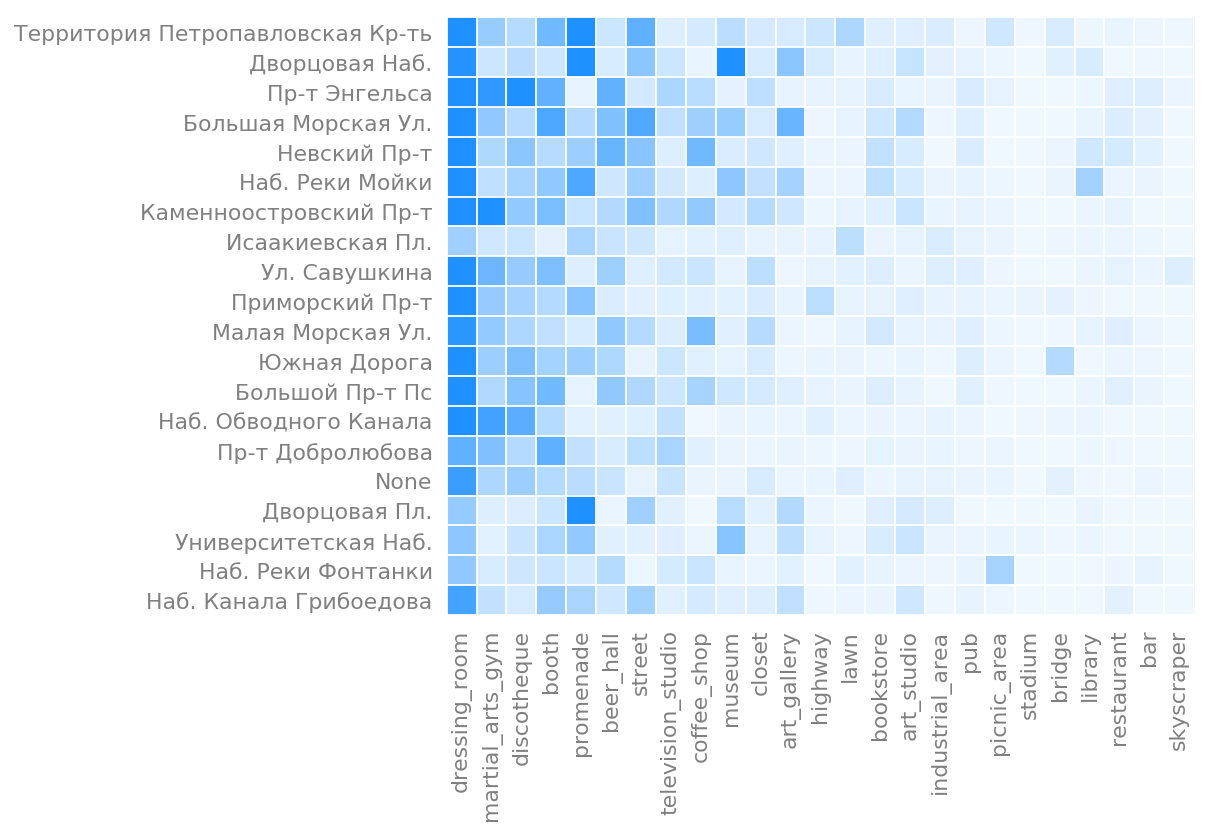

In [26]:
class StreetsFeaturesPlotStyle:
    FONT_SIZE = 11
    MAX_IM_VALUE = 24
    GRID_WIDTH = 0.9
    PLT_WIDTH = 9.5
    PLT_HEIGHT = 5.5
    PLOT_FACTOR = 0.7
    COLORMAP = 'Blues'
    LABEL_COLOR = 'grey'
    GRID_COLOR = 'white'
    CHINESE_RE = '[\u4e00-\u9fff]+'
    
    
def streets_features_plot(features_matrix, street_labels, tag_labels):
    style = StreetsFeaturesPlotStyle
    
    plt.figure(figsize=(style.PLT_WIDTH, 
                        style.PLT_HEIGHT))
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["aliceblue", "dodgerblue"])
    im = plt.imshow(features_matrix, 
                    cmap=cmap, vmax=style.MAX_IM_VALUE)

    ax = plt.gca()
    ax.set_xticks(np.arange(-0.5, N_SCENES, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, TOP_STREETS_VIS, 1), minor=True)

    ax.tick_params(width=0)
    ax.tick_params(which="minor", width=0)

    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_visible(False)
    
    plt.grid(which="minor", 
             color=style.GRID_COLOR, 
             linestyle='-', 
             linewidth=style.GRID_WIDTH)

    if re.findall(style.CHINESE_RE, " ".join(street_labels)):
        warnings.warn("Chinese characters will be hide because of bad matplotlib support")
        street_labels = [re.sub(style.CHINESE_RE, '', x).strip() for x in street_labels]
    
    if language == 'ru':
        street_labels = list(map(street_normalize_ru, street_labels))
    
    plt.xticks(range(N_SCENES), 
               tag_labels, rotation=90, 
               size=style.FONT_SIZE, 
               color=style.LABEL_COLOR)
    
    plt.yticks(range(TOP_STREETS_VIS), 
               street_labels, 
               size=style.FONT_SIZE, 
               color=style.LABEL_COLOR);
    
    
labels = [x.split("/")[0] for x in sorted_tags]
# FIXME
street_vectors = calculate_street_vectors(streets[:TOP_STREETS_VIS])
streets_features_plot(street_vectors, streets[:TOP_STREETS_VIS], labels)

In [27]:
def get_top_streets_tags():
    street_vectors = calculate_street_vectors(map_streets)

    street_tags = {}
    for u, v in zip(map_streets, street_vectors):
        sort = sorted(list(zip(labels[1:], v[1:])), 
                                                 key = lambda x: x[1], 
                                                 reverse=True)
        top = sort[0]
        val_sum = sum([x[1] for x in sort])
        street_tags[u] = [top[0], top[1]/val_sum]
    return street_tags


top_streets_tags = get_top_streets_tags()

In [28]:
class TaggedCityMapStyle:
    MARKER_SIZE = 17
    MARKER_OPACITY = 0.3
    MARKER_COLOR = 'dodgerblue'
    ZOOM = 12
    MARGIN = dict(l=0, r=30, b=0, t=20)
    MAP_WIDTH = 800
    MAP_HEIGHT = 470
    MAX_MARKER_SIZE = 40
    MIN_MARKER_SIZE = 3
    FONT_SIZE = 12
    FONT_COLOR = 'royalblue'
    MIN_LOCATIONS = 6

    
def tagged_city_map(lat, lon, streets, streets_locations_number, tags_labels):
    style = TaggedCityMapStyle
    
    tags_labels = [x if streets_locations_number.iloc[j] > style.MIN_LOCATIONS
                   else "" for j, x in enumerate(tags_labels)]
    
    marker_sizes = [x if x < style.MAX_MARKER_SIZE else style.MAX_MARKER_SIZE 
                    for x in streets_locations_number]
    marker_sizes = [x if x > style.MIN_MARKER_SIZE else style.MIN_MARKER_SIZE
                    for x in marker_sizes]

    data = [go.Scattermapbox(
                lat=lat,
                lon=lon,
                mode='markers+text',
                marker=dict(
                    size=marker_sizes,
                    color=style.MARKER_COLOR,
                    opacity=style.MARKER_OPACITY),
                text=tags_labels,
                textfont=dict(size=style.FONT_SIZE, color=style.FONT_COLOR),
                hoverinfo='none'
                )]

    layout = go.Layout(
                width=style.MAP_WIDTH,
                height=style.MAP_HEIGHT,
                hovermode='closest',
                margin=style.MARGIN,
                mapbox=dict(
                    accesstoken=MAPBOX_TOKEN,
                    center=dict(
                        lat=city_center[0],
                        lon=city_center[1]),
                    zoom=style.ZOOM,
                    style='light'
                ))

    fig = dict(data=data, layout=layout)
    py.iplot(fig, show_link=False)

    
tags_labels = []
for x in streets_table[STREET_COLUMN]:
    if np.isfinite(top_streets_tags[x][1]):
         tags_labels.append("{} {:.2f}".format(*top_streets_tags[x]))

tagged_city_map(streets_table['longtitude'], 
         streets_table['latitude'], 
         streets_table[STREET_COLUMN], 
         streets_table['counter'],
         tags_labels)

## Cities comparing

In [29]:
# cities features compare

cn = Counter()
for loc in list(data1.keys()):
    for photo in data1[loc]:
        for category, val in data1[loc][photo]['categories'].items():
            cn[category] += float(val)
            
all_tags = list(cn.keys())

all_tags.remove("beauty_salon")
all_tags.remove("dressing_room")

####

def build_tags_table(tags, scene_data):
    dd = []
    for loc in list(scene_data.keys()):
        cn = Counter()
        location_data = scene_data[loc]
        for photo in location_data:
            photo_data = scene_data[loc][photo]['categories'].items()
            for category, val in photo_data:
                cn[category] += float(val) / len(location_data)
        dd.append([loc, cn])

    dd1 = []
    for x in dd:
        dd1.append([x[0]] + [x[1][tag] for tag in tags])

    tags_table = pd.DataFrame(dd1)
    tags_table.columns=["id"] + tags
    
    return tags_table


selected_tags = get_tags('selected')

opposite_scenes = load_json(path_join(project_path, scenes_opposite_path))
target_scenes = load_json(path_join(project_path, scenes_path))

opposite_tags_table = build_tags_table(selected_tags, opposite_scenes)
target_tags_table = build_tags_table(selected_tags, target_scenes)

general_tags_table = np.vstack((target_tags_table[selected_tags].values.tolist(), 
                                opposite_tags_table[selected_tags].values.tolist()))
####

visual_data = TSNE().fit_transform(general_tags_table).T

####

target_path = path_join(project_path, photos_path)
opposite_path = path_join(project_path, photos_opposite_path)

loc_file_target = list(map(lambda x: x.strip().split(","), 
                           open(target_path + "loc_info.csv", "r").readlines()[1:]))

id2loc_target = {x[0]: x[1] for x in loc_file_target}

loc_file_opposite = list(map(lambda x: x.strip().split(","), 
                             open(opposite_path + "loc_info.csv", "r").readlines()[1:]))

id2loc_opposite = {x[0]: x[1] for x in loc_file_opposite}

In [30]:
N_TOP = 3
id2tags = {}
for index, row in target_tags_table.iterrows():
    top_idx = np.argsort(row[selected_tags].tolist())[-N_TOP:][::-1]
    top_tags = list(map(lambda x: x.split("/")[0], [selected_tags[x] for x in top_idx]))
    id2tags[row['id']] = top_tags
    
for index, row in opposite_tags_table.iterrows():
    top_idx = np.argsort(row[selected_tags].tolist())[-N_TOP:][::-1]
    top_tags = list(map(lambda x: x.split("/")[0], [selected_tags[x] for x in top_idx]))
    id2tags[row['id']] = top_tags

In [31]:
labels_opposite = ["{}<br>{}".format(trim(id2loc_opposite[x].replace("_", " ")), 
                                     ", ".join(id2tags[x]))
                   if x in id2loc_opposite else "_" 
                   for x in opposite_tags_table['id'].tolist()]

labels_target = ["{}<br>{}".format(trim(id2loc_target[x].replace("_", " ")), 
                                   ", ".join(id2tags[x]))
                 if x in id2loc_target else "_"  
                 for x in target_tags_table['id'].tolist()]

In [32]:
####

id2city = {}

for x in opposite_tags_table['id'].tolist():
    id2city[x] = opposite_city
    
for x in target_tags_table['id'].tolist():
    id2city[x] = CITY
    
####

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argsort(dist_2)

vis_list = list(visual_data.T)
all_ids = target_tags_table['id'].tolist() + \
                opposite_tags_table['id'].tolist()

n_closest_samples = 10
proportion_threshold = 0.7

indexes_target, indexes_opposite, indexes_other = [], [], []
for j in range(len(visual_data[0])):
    xc, yc = visual_data[0, j], visual_data[1, j]
    
    f_v = vis_list[:j] + vis_list[j+1:]
    closest_nodes = closest_node((xc, yc), f_v)[:n_closest_samples]
    curr_city = id2city[all_ids[j]]
    locations_cities = [id2city[all_ids[x]] for x in closest_nodes]
    if locations_cities.count(curr_city) / len(locations_cities) > proportion_threshold:
        if curr_city == CITY:
            indexes_target.append(j)
        elif curr_city == opposite_city:   
            indexes_opposite.append(j)
    else:   
        indexes_other.append(j)

###

colors = np.array(['dodgerblue'] * target_tags_table.shape[0] + 
                  ['red'] * opposite_tags_table.shape[0])

for j in indexes_other:
    colors[j] = 'aliceblue'

labels = np.array(labels_target + labels_opposite)

####

In [33]:
def min_diff(z, zarr):
    if len(zarr) > 1:
        return np.sort(np.abs(z - zarr))[1]
    else:
        return 10**6


idx2tag = {}
for index, row in target_tags_table.iterrows():
    top_idx = np.argsort(row[selected_tags].tolist())[-N_TOP:][::-1]
    top_tags = list(map(lambda x: x.split("/")[0], [selected_tags[x] for x in top_idx]))
    idx2tag[index] = top_tags[0]
    
for index, row in opposite_tags_table.iterrows():
    top_idx = np.argsort(row[selected_tags].tolist())[-N_TOP:][::-1]
    top_tags = list(map(lambda x: x.split("/")[0], [selected_tags[x] for x in top_idx]))
    idx2tag[index+target_tags_table.shape[0]] = top_tags[0]
    
tag_pos = {}
for tag in selected_tags:
    xm, ym = [], []
    for j in indexes_target + indexes_opposite:
        if j in idx2tag.keys() and idx2tag[j] == tag:
            xc, yc = visual_data[0, j], visual_data[1, j]
            xm.append(xc)
            ym.append(yc)
    tag_pos[tag] = [np.mean(xm), np.mean(ym)]
    
tag_labels, tag_labels_coordinates = [], []
for k in tag_pos:
    if not np.isnan(tag_pos[k][0]):
        tag_labels.append(k)
        tag_labels_coordinates.append(tag_pos[k])

        
min_hor_diff = 8.0
min_ver_diff = 8.0
        
showing_indexes = []
xarr, yarr = [], []
for j, (x, y) in enumerate(tag_labels_coordinates):
    dx, dy = min_diff(x, xarr), min_diff(y, yarr)
    if (dx > min_hor_diff and dy > min_ver_diff):
        showing_indexes.append(j)
        xarr.append(x)
        yarr.append(y) 
        
tag_labels = [x for j, x in enumerate(tag_labels) if j in showing_indexes]
tag_labels_coordinates = [x for j, x in enumerate(tag_labels_coordinates) if j in showing_indexes]

In [34]:
class LocationsScatterStyle:
    MARKER_OPACITY = 0.5
    MARKER_SIZE = 7
    PLOT_HEIGHT = 450
    PLOT_WIDTH = 600
    TARGET_COLOR = 'orangered'
    OPPOSITE_COLOR = 'gold'
    ANNOTATION_BACKGROUND = 'orangered'
    ANNOTATION_FONT_SIZE = 14
    ANNOTATION_OPACITY = 0.95
    ANNOTATION_FONT_COLOR = 'white'
    ANNOTATION_FONT_NAME = 'arial'
    MARGIN = dict(l=0, r=30, b=0, t=20)    

    
def locations_scatter_plot(locs_x, locs_y, 
                           opposite_locs_x,opposite_locs_y,
                          locs_labels, opposite_locs_labels):
    
    def create_scatter(x, y, colors, labels, name, size, opacity):
        return go.Scatter(x=x, y=y,
                          mode='markers',
                          hoverinfo='text', 
                          text=labels, name=name,
                          marker=dict(size=size, 
                                      color=colors,
                                      opacity=opacity))
    style = LocationsScatterStyle
    
    annotations = []
    
    for l, x, y in zip(tag_labels, 
                       [x[0] for x in tag_labels_coordinates], 
                       [x[1] for x in tag_labels_coordinates]):
        
        annotations.append(
            go.Annotation(x = x, y = y, 
                          xanchor="center",
                          showarrow=False, 
                          text="<i><b>{}".format(l),
                          opacity=style.ANNOTATION_OPACITY,
                          bgcolor=style.ANNOTATION_BACKGROUND,
                          font=dict(size=style.ANNOTATION_FONT_SIZE, 
                                    color=style.ANNOTATION_FONT_COLOR, 
                                    family=style.ANNOTATION_FONT_NAME)))
    
    data = [create_scatter(locs_x, locs_y, 
                           style.TARGET_COLOR, 
                           locs_labels, CITY,
                           style.MARKER_SIZE, 
                           style.MARKER_OPACITY),
            
            create_scatter(opposite_locs_x, opposite_locs_y, 
                           style.OPPOSITE_COLOR, 
                           opposite_locs_labels, 
                           opposite_city,
                           style.MARKER_SIZE, 
                           style.MARKER_OPACITY)]

    axis_style = dict(showticklabels=False, zeroline=False)
    
    layout = go.Layout(height=style.PLOT_HEIGHT, 
                       width=style.PLOT_WIDTH,
                       margin=style.MARGIN, 
                       hovermode='closest',
                       xaxis=axis_style, 
                       yaxis=axis_style)
    
    fig = go.Figure(data=data, layout=layout)
    fig['layout']['annotations'] = annotations
    py.iplot(fig, show_link=False)


locations_scatter_plot(np.array(visual_data[0])[indexes_target],
                       np.array(visual_data[1])[indexes_target], 
                       np.array(visual_data[0])[indexes_opposite],
                       np.array(visual_data[1])[indexes_opposite],
                       labels[indexes_target], labels[indexes_opposite])

In [35]:
tags_delta([x[0] for x in sc_delta], [x[1] for x in sc_delta])